In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('../input/fer2013/fer2013.csv')

In [4]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
import cv2
#加载csv文件，将数据和标签分离

def load_fer(csv_file,mode):
    content = pd.read_csv('../input/fer2013/fer2013.csv')
    data = content[content['Usage'] == mode]
    pixels = data['pixels'].tolist()#将像素转换为列表
    width,height = 48,48#图像的宽和高
    faces = [] #存放每张图像的像素信息
    for pixel_seq in pixels:
        face = [int(pixel) for pixel in pixel_seq.split()]
        face = np.array(face) #转换为数组
        face = face.reshape(width,height) #调整图像维度
        face = cv2.resize(face.astype('uint8'),(48,48))
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces,-1) #增加最后的通道维度
    emotions = pd.get_dummies(data['emotion']).values
    return faces,emotions
face_train,emotion_train = load_fer('../input/fer2013/fer2013.csv','Training')
face_val,emotion_val = load_fer('../input/fer2013/fer2013.csv','PublicTest')
face_test,emotion_test = load_fer('../input/fer2013/fer2013.csv','PrivateTest')
print(face_train.shape)
print(emotion_train.shape)
print(face_val.shape)
print(emotion_val.shape)
print(face_test.shape)
print(emotion_test.shape)

(28709, 48, 48, 1)
(28709, 7)
(3589, 48, 48, 1)
(3589, 7)
(3589, 48, 48, 1)
(3589, 7)


In [6]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
#增强数据，扩充数据集的大小
data_gen = ImageDataGenerator(
    featurewise_center = False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    horizontal_flip=True)
train_gen = data_gen.flow(face_train, emotion_train, batch_size)
val_gen = data_gen.flow(face_val, emotion_val, batch_size)
test_gen = data_gen.flow(face_test,emotion_test, batch_size)


In [7]:
print(len(train_gen))
print(len(val_gen))
print(len(test_gen))

898
113
113


In [8]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [9]:
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    #首先对数据进行正则化，可以避免数据集出现过拟合的现象
    '''数据预处理：
    1、归一化：将训练集中某一列数值特征的值缩放到0-1之间,当目标受多个不同维度的特征制约时，例如影响房子价格的因素包括：房子的面积、房子的年代等，数值相差比较大时，归一到同一区间
        [Xi-min(Xi)]/[max(Xi)-min(Xi)]
    2、标准化：将训练集中某一列的特征缩放成均值为0，方差为1的状态，标准化后数据范围不一定是0-1之间，数据分布不会改变
        [Xi-x(均值)]/sd(x)
        在PCA、聚类、逻辑回归、支持向量机、神经网络中常用到标准化
    归一化、标准化都是对某个特征进行缩放而不是对某个样本的特征向量进行缩放
    目的：提高模型的精度、提升收敛的速度
    3、正则化：当需要保持数据的原始量纲的情况下，不能对数据进行标准化或者归一化处理
    正则化主要用来防止过拟合，对于损失函数添加上正则项，求约束函数和正则化项之和的最小值'''
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    #先对通道进行卷积减小维度，再对空间进行卷积，最终输出16通道的特征图
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


In [10]:
import os
os.mkdir('models/')

In [11]:
num_epochs=100
input_shape=(48,48,1)
verbose = 1
num_classes=7
patience = 50
base_path = 'models/'
model = mini_XCEPTION(input_shape,num_classes)
model.compile(optimizer='adam', # 优化器采用adam
              loss='categorical_crossentropy', # 多分类的交叉熵损失函数
              metrics=['accuracy'])
model.summary()
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss',patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/4),
                              verbose=1)
#存放模型位置及命名
trained_models_path = base_path + '_mini_XCEPTION'
#模型的名字命名：.epoch+准确率.hdf5
model_names = trained_models_path + '.{epoch:02d}-accuracy{accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names,
                                   'val_loss', verbose=1,
                                    save_best_only=True)
#进行断点的恢复
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
result = model.fit_generator(train_gen,steps_per_epoch=len(face_train) / batch_size,
                        epochs=num_epochs,
                        verbose=1, callbacks=callbacks,
                        validation_data=(face_val,emotion_val))


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

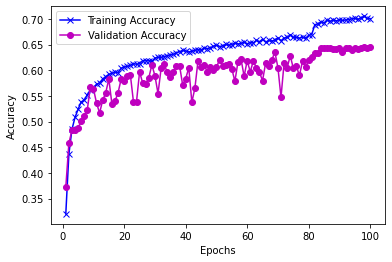

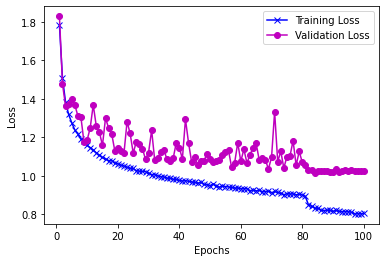

In [12]:
#迭代了100个epoch,仅得到了0.68的准确率
import matplotlib.pyplot as plt
acc = result.history['accuracy'] #得到训练过程中的准确率和损失
loss = result.history['loss']
validation_acc = result.history['val_accuracy'] #验证集的准确率和损失
validation_loss = result.history['val_loss']

x = range(1,len(acc)+1)

plt.plot(x,acc,'x-b',label = 'Training Accuracy')
plt.plot(x,validation_acc,'o-m',label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(x,loss,'x-b',label = 'Training Loss')
plt.plot(x,validation_loss,'o-m',label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
